In [46]:
import numpy as np
import matplotlib.pyplot as plt 

from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.core.problem import ElementwiseProblem

In [47]:
class Graph:
    
    def __init__( self, number_of_nodes, x_bounds, y_bounds, precision ):
        
        self.number_of_nodes = number_of_nodes
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds
        self.precision = precision
        
        self.nodes = None
        self.distance_matrix = None
        
        self.connectivity_matrix = None
        
    def generate_nodes( self, random_seed ):
        
        # set random seed
        np.random.seed( random_seed )
        
        # generate random nodes with a set number of decimals
        nodes = np.round( \
            np.random.rand( self.number_of_nodes, 2 ) * \
            np.array( [ self.x_bounds[1] - self.x_bounds[0], self.y_bounds[1] - self.y_bounds[0] ] ) + \
            np.array( [ self.x_bounds[0],  self.y_bounds[0] ] ), \
        decimals=self.precision )
        
        self.nodes = nodes
        
        # initilize an empty distance matrix with each location contaning np.inf
        distance_matrix = np.full( ( self.number_of_nodes, self.number_of_nodes ), np.inf )
        
        # fill distance matrix with the euclidian distance between each points
        for i in range( 0, self.number_of_nodes - 1 ):
            for j in range( i+1, self.number_of_nodes ):
                distance_matrix[i][j] = np.round( 
                    np.sqrt( ( nodes[i][0] - nodes[j][0] )**2 + \
                             ( nodes[i][1] - nodes[j][1] )**2 \
                    ), \
                decimals=self.precision )
                
                distance_matrix[j][i] = distance_matrix[i][j]
                
        self.distance_matrix = distance_matrix
        
    def set_connectivity( self, connection_order ):
                
        connectivity_matrix = np.full( ( self.number_of_nodes, self.number_of_nodes ), 0 )
        
        previous = 0
        for i, connection in enumerate( connection_order ):
            connectivity_matrix[previous][connection] = i+1
            previous = connection
            
        self.connectivity_matrix = connectivity_matrix
        
    def print_matrix( self ):
        print( '        \x1b[1;97m', end='' )
        for i in range( 0, self.number_of_nodes ):
            print( f'{i+1}  ', end='' )
        print( '' )
        
        for i in range( 0, self.number_of_nodes ):
            print( f'{i+1} -> : ', end='' )
            for j in range( 0, self.number_of_nodes ):
                number = self.distance_matrix[i][j]
                number = f'{number:.0f} ' if number != np.inf else '   '
                
                if self.connectivity_matrix is not None and self.connectivity_matrix[i][j] != 0:
                    print( '\x1b[1;31m', end='' )
                print( f'{number}\x1b[1;97m', end='' )
            print('')

    def display_graph( self, edge_offset ):
        
        fig, ax = plt.subplots()
        fig.set_dpi( 200 )
        
        
        if self.nodes is not None:
            
            # set bounds of graph
            ax.set_xlim( np.min( self.nodes[:, 0] - edge_offset ), np.max( self.nodes[:, 0] + edge_offset ) )
            ax.set_ylim( np.min( self.nodes[:, 1] - edge_offset ), np.max( self.nodes[:, 1] + edge_offset ) )
            
            # nodes
            ax.scatter( self.nodes[:, 0], self.nodes[:, 1], s=200, c='black', zorder=1 )
            
            # node labels
            for i, node in enumerate( self.nodes ):
                ax.annotate( i+1, ( node[0], node[1] ), c='white', ha='center', va='center', )
                
            # edges
            for i in range( 0, self.number_of_nodes ):
                for j in range( i+1, self.number_of_nodes ):
                    ax.plot( [ self.nodes[i, 0], self.nodes[j, 0] ], \
                             [ self.nodes[i, 1], self.nodes[j, 1] ], \
                             'k-.', alpha=0.5, linewidth=0.5, zorder=0 )    
                    
                    # edge labels
                    ax.text( ( self.nodes[i, 0] + self.nodes[j, 0]) / 2, \
                             ( self.nodes[i, 1] + self.nodes[j, 1]) / 2, \
                             f'{self.distance_matrix[i, j]:.0f}', \
                             ha='center', va='center', \
                             bbox=dict( boxstyle='round,pad=0.3', fc='gray', alpha=0.3 ), \
                             zorder=1 )               
            
            # connections
            if self.connectivity_matrix is not None:
                for i in range( 0, self.number_of_nodes ):
                    for j in range( 0, self.number_of_nodes ):
                        if self.connectivity_matrix[i][j] != 0:
                            
                            # arrows
                            ax.arrow( self.nodes[i, 0], self.nodes[i,1], \
                                    ( self.nodes[j, 0] - self.nodes[i, 0] ) / 3, \
                                    ( self.nodes[j, 1] - self.nodes[i, 1] ) / 3, \
                                    head_width=1, head_length=1, color='red', zorder=0 )
                            
                            # arrow labels
                            x = ( self.nodes[i, 0] + ( self.nodes[j, 0] - self.nodes[i, 0] ) * 1/4 )
                            y = ( self.nodes[i, 1] + ( self.nodes[j, 1] - self.nodes[i, 1] ) * 1/4 )
                            
                            ax.text( x, y, f'{self.connectivity_matrix[i][j]}',
                                     ha='center', va='center', zorder=1, fontsize=6,
                                     bbox=dict(boxstyle='circle,pad=0.3', fc='white', ec='black') )  
            
        plt.show()

In [ ]:
class Path ( ElementwiseProblem ):

    def __init__( self, graph ):
        
        self.graph = graph
        super().__init__( n_var=graph.number_of_nodes-1, n_obj=1, n_ieq_constr=0, xl=1, xu=graph.number_of_nodes-1 )

    def _evaluate( self, x, out, *args, **kwargs ):
        
        self.graph.set_connectivity( x )
        
        distance_mask = np.where( self.graph.connection_matrix != 0, self.graph.distance_matix, 0 )
        
        out["F"] = np.sum( distance_mask )
        
        # out["G"] = np.column_stack([0.1 - out["F"], out["F"] - 0.5])

        1  2  3  4  
1 -> :    72 29 45 
2 -> : 72    51 77 
3 -> : 29 51    62 
4 -> : 45 77 62    


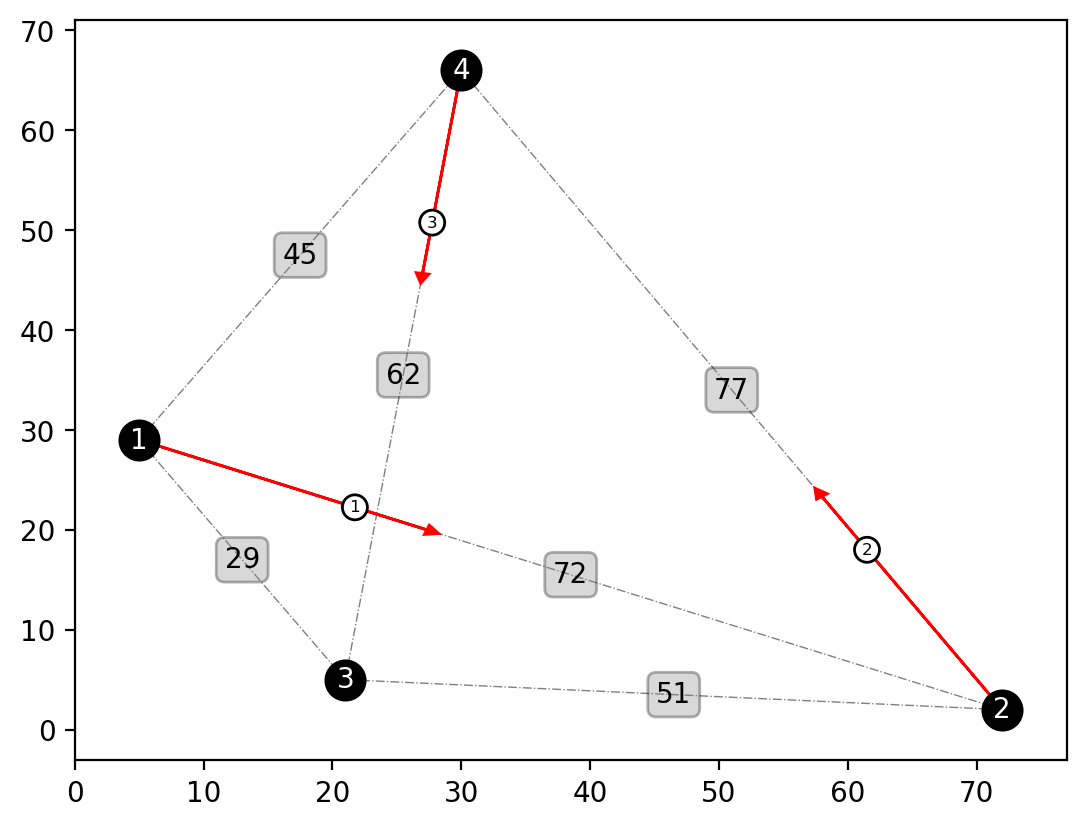

In [48]:
# ========== #
# Parameters #
# ========== #

number_of_nodes = 4

G = Graph( number_of_nodes=number_of_nodes, x_bounds=[ 0, 100 ], y_bounds=[ 0, 100 ], precision=0 )
.generate_nodes( random_seed=21 )



G.set_connectivity( connection_order=np.array( [ 1, 3, 2 ] ) )
G.print_matrix()
G.display_graph( edge_offset=5 )